Adithya Palle \
March 30, 2025 \
Final Project

Jupyter Notebook for visualizing the data used for the testing videos and the images used to train the CNN.


In [1]:
from data_extraction import get_video_data, display_images, display_video,get_image_data

In [2]:


fire_videos, nofire_videos = get_video_data()

torch.Size([513, 3, 272, 480])


TypeError: Invalid shape (3, 272, 480) for image data

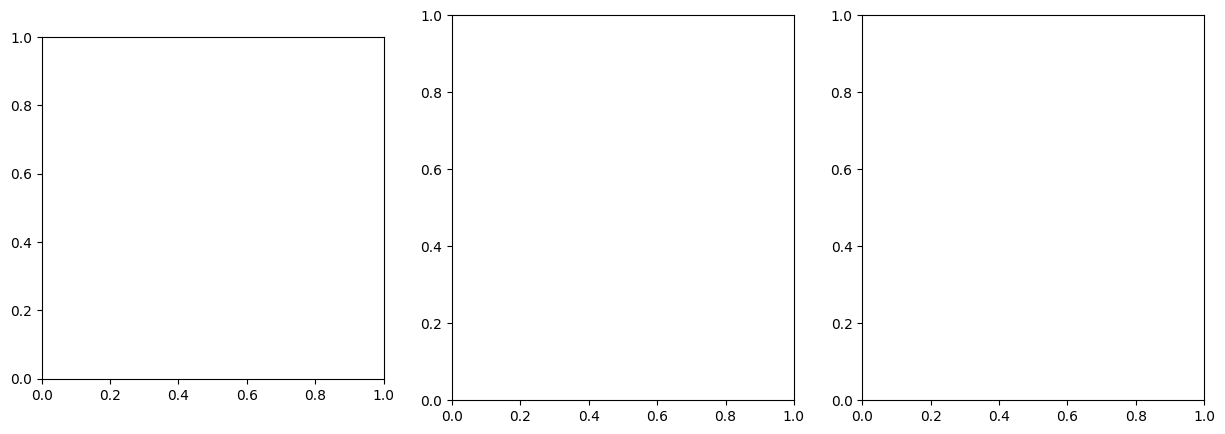

In [3]:
print(fire_videos[0].shape)  # Print the shape of the first video tensor


# Display the first 5 frames of the first video
display_video(fire_videos[0], num_frames=3)
# Display the first 5 frames of the first nofire video
display_video(nofire_videos[0], num_frames=3)


In [ ]:


train_images, val_images, test_images = get_image_data(1000)


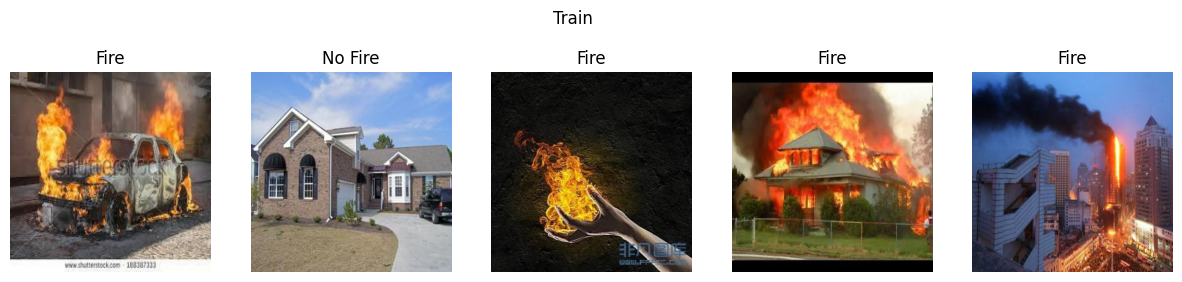

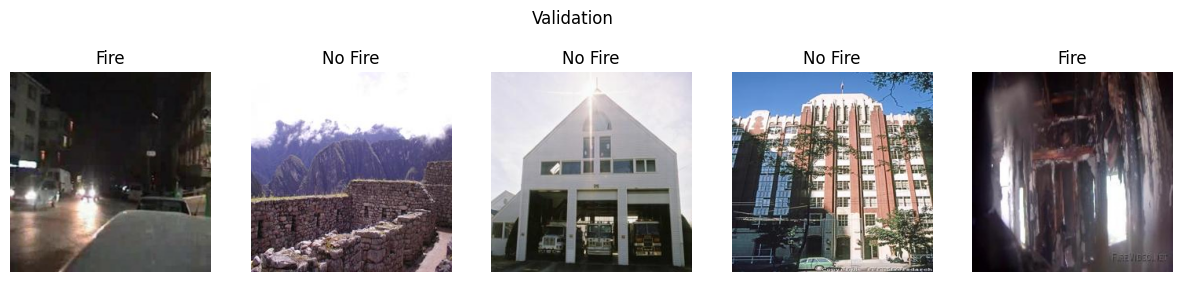

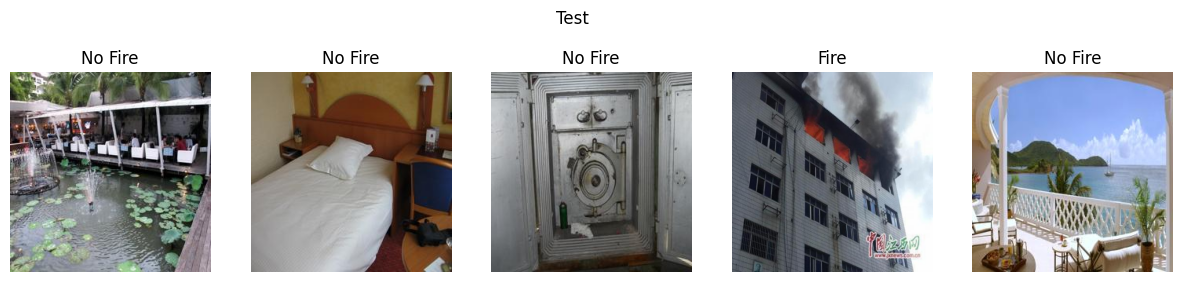

In [ ]:

# show random 5 training images
display_images(train_images, num_images=5, title = "Train")
# show random 5 validation images
display_images(val_images, num_images=5, title = "Validation")
# show random 5 test images
display_images(test_images, num_images=5 , title = "Test")